# Wine dataset: Implementing a Multiclass Classifier

**D3APL: Aplicações em Ciências de Dados**

Especialização em Ciência de Dados - IFSP Campinas

Alunos
- Daniel Vargas Shimamoto
- Diego Machado de Assis

## 1. Set up

#### Imports

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#### Creating fake data

In [2]:
# fake data for testing
X, y = make_blobs(n_samples=10000, n_features=2, centers=2, cluster_std=2.5, random_state=42)

print(X.shape)
print(y.shape)
print(f'Labels: {np.unique(y)}')

(10000, 2)
(10000,)
Labels: [0 1]


In [3]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (8000, 2)
y_train.shape = (8000,)
X_test.shape = (2000, 2)
y_test.shape = (2000,)


In [4]:
# feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Text(0.5, 1.0, 'Scatter plot: Training Samples')

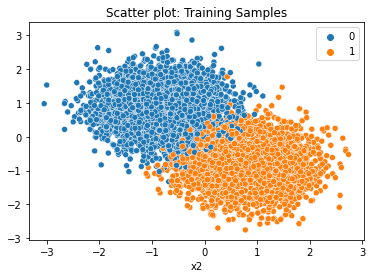

In [5]:
import seaborn as sns

sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train)
plt.xlabel('x1')
plt.xlabel('x2')
plt.title('Scatter plot: Training Samples')

Text(0.5, 1.0, 'Scatter plot: Testing Samples')

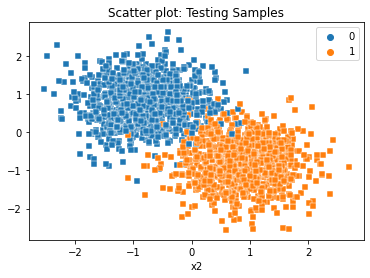

In [6]:
import seaborn as sns

sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, marker='s')
plt.xlabel('x1')
plt.xlabel('x2')
plt.title('Scatter plot: Testing Samples')

## 2. Implementation

In [7]:
from typing import Tuple

import numpy as np
from numpy import ndarray

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.base import BaseEstimator, ClassifierMixin


class LogisticRegression(ClassifierMixin, BaseEstimator):
    """Logistic Regression Classifier with SDG training.
    
    Parameters
    ----------
    learning_rate : float, default=0.001
        Learning rate.

    n_epochs : int, default=1000
        Number of epochs for training (convergence stop).

    alpha : float, default=0.0001
        Constant that multiplies the regularization term.
        Use 0 to ignore regularization (standard Logistic Regression).
        
    optimizer : str, defatult='batch'
        Gradient descent optimizer strategy
        
    minibatch_size : int, default=20
        Batch size when optimizer='mini'

    random_state : int, default=42
        Seed used for generating random numbers.
        
    Attributes
    ----------
    coef_ : ndarray of shape (1, n_features) if n_classes == 2 else \
            (n_classes, n_features)
        Weights assigned to the features.
        
    intercept_ : ndarray of shape (1,) if n_classes == 2 else (n_classes,)
        Intercept (a.k.a. bias) added to the decision function.
    """
    
    def __init__(
        self,
        learning_rate: float = 0.001,
        n_epochs: int = 1000,
        alpha: float = 0.0001,
        optimizer: str = "batch",
        minibatch_size: int = 20,
        random_state: int = 42
    ):

        assert (learning_rate is not None) and (learning_rate > 0.0), \
        f'Learning rate must be > 0. Passed: {learning_rate}'
        
        assert (n_epochs is not None) and (n_epochs > 0), \
        f'Number of epochs must be > 0. Passed: {n_epochs}'
        
        assert (alpha is not None) and (alpha >= 0), \
        f'Alpha should be >= 0. Passed: {alpha}'
        
        assert optimizer in ['batch', 'mini', 'stochastic'], \
        f'Optimizer "{optimizer}" is not supported'
        
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.alpha = alpha
        self.optimizer = optimizer
        self.minibatch_size = minibatch_size
        self.random_state = random_state
        
        
        # parameters to be trained/learned
        self.__w = None  # weight array
        self.__b = None  # bias
    
    
    # a special method used to represent a class object as a string, called with print() or str()
    def __str__(self):
        msg = f"""
        Learning rate: {self.learning_rate}
        Number of epochs: {self.n_epochs}
        Regularization constant (alpha): {self.alpha}
        Optimizer (optimizer): {self.optimizer}
        Random state: {self.random_state}
        
        Trained?: {self.is_fitted()}
        """

        return msg
    
    
    @property
    def coef_(self) -> ndarray:
        """Return the weight matrix (learned parameters) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__w
    

    @property
    def intercept_(self) -> float:
        """Return the bias (learned intercepet) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__b
    
    
    def is_fitted(self) -> bool:
        return self.__w is not None
    
    
    def __sigmoid(self, z: ndarray) -> ndarray:
        return 1 / (1 + np.e ** (-z))
    
    
    def __log_loss(self, y: ndarray, p_hat: ndarray, eps: float = 1e-15):
        """Return the log loss for a given estimation and ground-truth (true labels).
        
        log is undefined for 0. Consequently, the log loss is undefined for `p_hat=0` (because of log(p_hat)) and `p_hat=1` (because of ln(1 - p_hat)).
        To overcome that, we clipped the probabilities to max(eps, min(1 - eps, p_hat)), where `eps` is a tiny constant. 

        Parameters
        ----------
        y : ndarray, shape (n_samples,)
            True labels of input samples.
        p_hat : ndarray
            Estimated probabilities of input samples.
        eps : float, default=1e-15
            Epsilon term used to avoid undefined log loss at 0 and 1.
        
        Returns
        -------
        log_loss : float
            Computed log loss.
        """
        
        p_hat_eps = np.maximum(eps, np.minimum(1 - eps, p_hat))
        
        # shape: (n_samples,)
        losses = -(y * np.log(p_hat_eps) + (1 - y) * np.log(1 - p_hat_eps))
        log_loss = losses.mean()
        
        return log_loss
    
    
    def __gradient(
        self,
        X: ndarray,
        y: ndarray,
        p_hat: ndarray,
        w: ndarray,
        alpha: float
    ) -> Tuple[ndarray, float]:
        '''Compute the gradient vector for the log loss with regards to the weights and bias.
        
        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        p_hat : ndarray, shape (n_samples,)
            Estimated probabilities.
        w : ndarray, shape (n_features,)
            Weight array.
        alpha : float
            Reguralization constant.
        
        Returns
        -------
        Tuple[ndarray, float]: 
            Tuple with:
            - a numpy array of shape (n_features,) containing the partial derivatives w.r.t. the weights; and
            - a float representing the partial derivative w.r.t. the bias.
        '''
        # X.shape: (n_samples, n_features)
        # y.shape == p_hat.shape: (n_samples,)
        n_samples = X.shape[0]
        
        regularization = alpha * w
        
        error = p_hat - y  # shape (n_samples,)
        grad_w = (np.dot(error, X) / n_samples) + regularization  # shape (n_features,)
        grad_b = error.mean()  # float
        
        return grad_w, grad_b
    
    def __shuffle(self, X: ndarray, y: ndarray) -> Tuple[ndarray, ndarray]:
        p = np.random.permutation(len(y))
        return X[p], y[p]

    
    def fit(self, X: ndarray, y: ndarray, verbose: int = 0):
        '''Train a Logistic Regression classifier.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        verbose: int, default=0
            Verbose flag. Print training information every `verbose` iterations.
            
        Returns
        -------
        self : object
            Returns self.
        '''
        ### CHECK INPUT ARRAY DIMENSIONS
        assert X.ndim == 2, f'X must be 2D. Passed: {X.ndim}'
        assert y.ndim == 1, f'y must be 1D. Passed: {y.ndim}'
        assert X.shape[0] == y.shape[0], \
            f'X.shape[0] should be equal to y.shape[0], instead: {X.shape[0]} != {y.shape[0]}'
        # alternatively
        # X, y = check_X_y(X, y)

        ### SETTING SEED
        np.random.seed(self.random_state)
        
        n_samples, n_features = X.shape

        ### PARAMETER INITIALIZATION
        # return values from the “standard normal” distribution.
        w = np.random.randn(n_features)  # shape: (n_features,)
        b = np.random.randn()
        
        # values of each iteration
        losses = []
        weights = [w]
        biases = [b]
        
        if self.optimizer == 'stochastic':
            batch_size = 1
        elif self.optimizer == 'mini':
            batch_size = self.minibatch_size
        else:
            batch_size = n_samples
        
        # LEARNING ITERATIONS
        for epoch in range(self.n_epochs):
            # X, y = self.__shuffle(X, y)
            for i in range(0, n_samples, batch_size):
                X_b = X[i:i + batch_size]
                y_b = y[i:i + batch_size]
                
                ### ESTIMATION (FORWARD PASS)
                z = np.dot(X_b, w) + b
                p_hat = self.__sigmoid(z)
            
                ### LOSS
                J = self.__log_loss(y_b, p_hat)
            
                ### GRADIENT DESCENT UPDATES (BACKWARD PASS)
                grad_w, grad_b = self.__gradient(X_b, y_b, p_hat, w, self.alpha)
                w = w - self.learning_rate * grad_w
                b = b - self.learning_rate * grad_b
                
                losses.append(J)
                weights.append(w)
                biases.append(b)
                            
            if verbose and (epoch == 0 or (epoch + 1) % verbose == 0):
                print(f'[INFO] epoch={epoch + 1}/{self.n_epochs}, loss={J:.7f}')

        ### ASSIGN THE TRAINED PARAMETERS TO THE PRIVATE ATTRIBUTES
        self.__w = weights[-1]
        self.__b = biases[-1]
        
        if verbose:
            losses = np.array(losses)
            print(f'\nFinal loss: {losses[-1]}')
            print(f'\nMean loss: {losses.mean()} +- {losses.std()}')
            
            fig = plt.figure(figsize=(16,8), tight_layout=True)
            gs = GridSpec(3, 3, figure=fig)
            
            ax1 = fig.add_subplot(gs[:, :-1])
            ax2 = fig.add_subplot(gs[0, -1])
            ax3 = fig.add_subplot(gs[1, -1])
            ax4 = fig.add_subplot(gs[2, -1])
            
            sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax1)
 
            w_lines = weights[:-1:verbose] + [ weights[-1] ]
            b_lines = biases[:-1:verbose] + [ biases[-1] ]
            colors = sns.color_palette("crest", n_colors=len(w_lines))
            for i, (w1, w2), b in zip(range(len(w_lines)), w_lines, b_lines):
                x1_decision_line = np.array([X[:, 0].min(), X[:, 0].max()])
                x2_decision_line = -(b + (w1 * x1_decision_line)) / w2
                sns.lineplot(x=x1_decision_line, y=x2_decision_line, color=colors[i], ax=ax1)
                
            ax1.set_xlabel('x1')
            ax1.set_ylabel('x2')
            ax1.set_xlim(X[:, 0].min(), X[:, 0].max())
            ax1.set_ylim(X[:, 1].min(), X[:, 1].max())
            ax1.set_title('Updates of Decision Boundary on Training Samples')
            
            weights = np.array(weights)
            biases = np.array(biases)
            sns.lineplot(x=weights[:, 0], y=biases, ax=ax2)
            ax2.set(title="Evolution of w1 x b", xlabel="w1", ylabel="b")
            
            sns.lineplot(x=weights[:, 1], y=biases, ax=ax3)
            ax3.set(title="Evolution of w2 x b", xlabel="w2", ylabel="b")
            
            sns.lineplot(x=weights[:, 0], y=weights[:, 1], ax=ax4)
            ax4.set(title="Evolution of w1 x w2", xlabel="w1", ylabel="w2")
            
            plt.show()
    
    
    def predict_proba(self, X: ndarray) -> ndarray:
        '''Estimate the probability for the positive class of input samples.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            The estimated probabilities for the positive class of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must b 2D. Passed: {X.ndim}'

        z = np.dot(X, self.__w) + self.__b
        p_hat = self.__sigmoid(z)
        
        return p_hat
    
        
        
    def predict(self, X: ndarray) -> ndarray:
        '''Predict the labels for input samples.
        
        Thresholding at probability >= 0.5.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            Predicted labels of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must b 2D. Passed: {X.ndim}'
        
        p_hat = self.predict_proba(X)
        y_hat = p_hat >= 0.5  # array of bools
        y_hat = y_hat.astype(int)
        
        return y_hat

#### **Testing `fit()`**

[INFO] epoch=1/10000, loss=0.5251873
[INFO] epoch=1000/10000, loss=0.3850218
[INFO] epoch=2000/10000, loss=0.3083365
[INFO] epoch=3000/10000, loss=0.2614185
[INFO] epoch=4000/10000, loss=0.2300158
[INFO] epoch=5000/10000, loss=0.2075545
[INFO] epoch=6000/10000, loss=0.1906743
[INFO] epoch=7000/10000, loss=0.1775019
[INFO] epoch=8000/10000, loss=0.1669166
[INFO] epoch=9000/10000, loss=0.1582086
[INFO] epoch=10000/10000, loss=0.1509074

Final loss: 0.15090735198641536

Mean loss: 0.24082185611872906 +- 0.09018478722084376


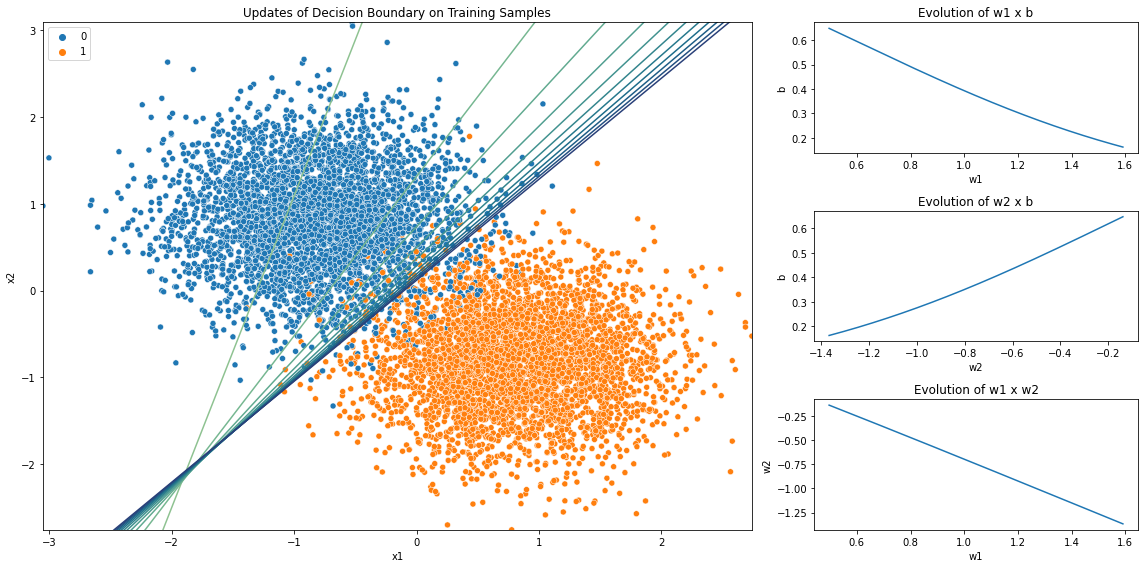

In [8]:
clf = LogisticRegression(n_epochs=10000)
clf.fit(X_train, y_train, verbose=1000)

[INFO] epoch=1/2, loss=0.7284340

Final loss: 0.8022102031425569

Mean loss: 0.20105841236092553 +- 0.21557957641220174


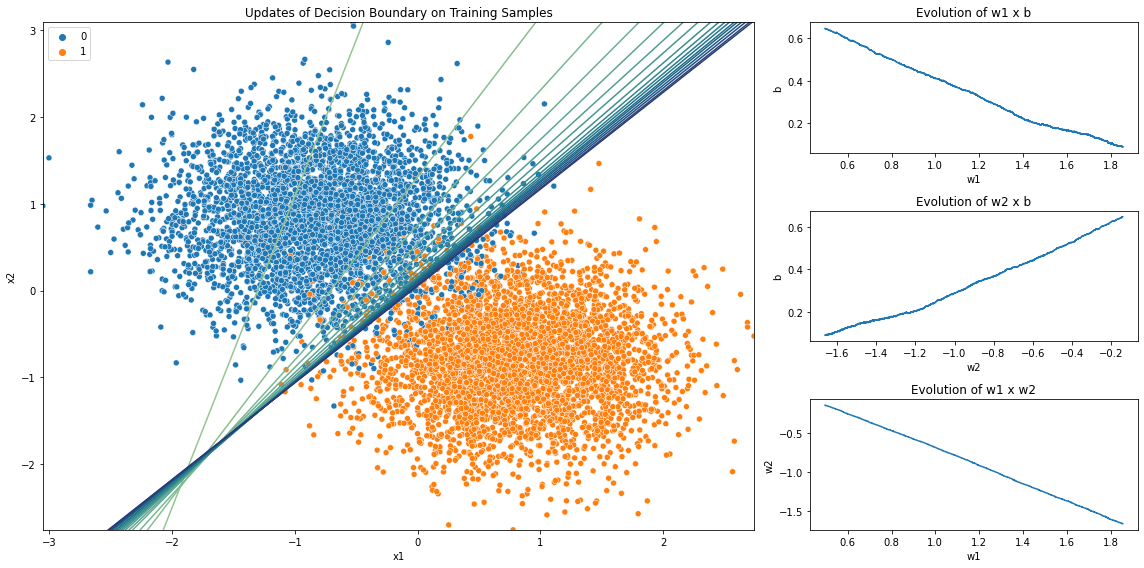

In [9]:
clf = LogisticRegression(n_epochs=2, optimizer='stochastic')
clf.fit(X_train, y_train, verbose=1000)

[INFO] epoch=1/200, loss=0.5189349

Final loss: 0.11411565567102971

Mean loss: 0.20131696935614987 +- 0.08971324016589702


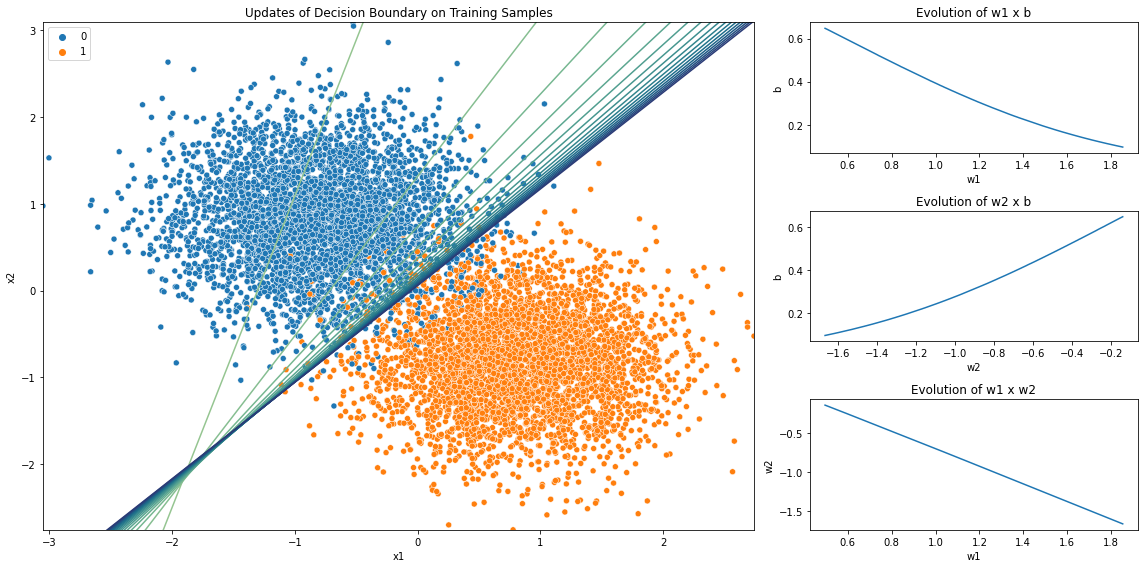

In [10]:
clf = LogisticRegression(n_epochs=200, optimizer='mini', minibatch_size=100)
clf.fit(X_train, y_train, verbose=1000)

#### **Visualizing the Decision Boundary**
L2 regularization with alpha=100, n_epochs=10000.

$w_1x_1 + w_2x_2 + b = 0$

$x_2 = -(b + w_1x_1)/w_2$

In [11]:
b = clf.intercept_
w1, w2 = clf.coef_

In [12]:
w1, w2, b

(1.852845656589808, -1.6645467141426695, 0.09631279839144448)

In [13]:
x1_decision_line = np.array([X_train[:,0].min(), X_train[:,0].max()])
x2_decision_line = -(b + (w1 * x1_decision_line)) / w2

Text(0.5, 1.0, 'Decision Boundary on Training Samples')

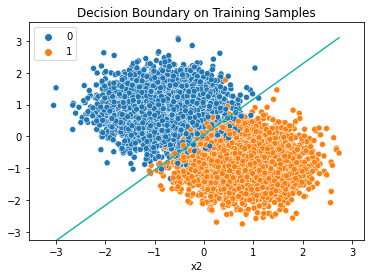

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train)
sns.lineplot(x=x1_decision_line, y=x2_decision_line, color='lightseagreen')
plt.xlabel('x1')
plt.xlabel('x2')
ax.set_xlim(X_train[:,0].min() - 0.5, X_train[:,0].max() + 0.5)
ax.set_ylim(X_train[:,1].min() - 0.5, X_train[:,1].max() + 0.5)
plt.title('Decision Boundary on Training Samples')

Text(0.5, 1.0, 'Decision Boundary on Testing Samples')

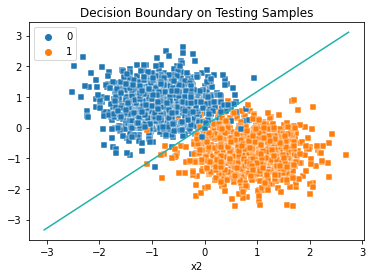

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, marker='s')
sns.lineplot(x=x1_decision_line, y=x2_decision_line, color='lightseagreen')
plt.xlabel('x1')
plt.xlabel('x2')
plt.title('Decision Boundary on Testing Samples')

### Prediction

In [16]:
y_test_pred = clf.predict(X_test)

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1002
           1       0.98      0.98      0.98       998

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

